In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

# 🔹 STEP 1: Load Datasets
companies = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-companies.csv", encoding='latin1', low_memory=False)
funding_rounds = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-rounds.csv", encoding='latin1', low_memory=False)
investments = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-investments.csv", encoding='latin1', low_memory=False)
acquisitions = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-acquisitions.csv", encoding='latin1', low_memory=False)

# 🔹 STEP 2: Filter & Rename Columns for Consistency
companies = companies[companies['founded_year'] <= 2013]  # Keep only companies founded before 2013
companies.rename(columns={'permalink': 'company_permalink'}, inplace=True)

# 🔹 Handle Missing Values - Founded Year (Regression Imputation)
companies['permalink_length'] = companies['company_permalink'].str.len()  # Feature for regression
train_data = companies.dropna(subset=['founded_year'])
test_data = companies[companies['founded_year'].isnull()]

X_train = train_data[['permalink_length']]
y_train = train_data['founded_year']
X_test = test_data[['permalink_length']]

reg = LinearRegression()
reg.fit(X_train, y_train)
companies.loc[companies['founded_year'].isnull(), 'founded_year'] = reg.predict(X_test)

# 🔹 Handle Missing Values - Funding (Linear Interpolation)
companies['funding_total_usd'] = companies['funding_total_usd'].interpolate(method='linear')

# 🔹 Handle Categorical Missing Values (Mode Imputation)
companies['category_code'] = companies['category_code'].fillna(companies['category_code'].mode()[0])

# 🔹 Convert Founded Year to Company Age
companies['company_age'] = 2013 - companies['founded_year']

# 🔹 Drop Unnecessary Columns
companies.drop(['founded_at', 'closed_at', 'category_code'], axis=1, inplace=True, errors='ignore')

# 🔹 STEP 3: Aggregate Funding Data
funding_rounds['raised_amount_usd'] = funding_rounds['raised_amount_usd'].fillna(0)
funding_agg = funding_rounds.groupby('company_permalink')['raised_amount_usd'].sum().reset_index()
funding_agg.rename(columns={'raised_amount_usd': 'total_funding_received'}, inplace=True)

# 🔹 STEP 4: Aggregate Investment Data
investor_count = investments.groupby('company_permalink')['investor_permalink'].nunique().reset_index()
investor_count.rename(columns={'investor_permalink': 'num_investors'}, inplace=True)

# 🔹 STEP 5: Label Acquisitions
acquisitions['acquired'] = 1
acquisitions = acquisitions[['company_permalink', 'acquired']]

# 🔹 STEP 6: Merge Processed Data
final_df = companies.merge(funding_agg, on='company_permalink', how='left')
final_df = final_df.merge(investor_count, on='company_permalink', how='left')
final_df = final_df.merge(acquisitions, on='company_permalink', how='left')

# 🔹 Fill Remaining Missing Values (KNN Imputer)
knn_imputer = KNNImputer(n_neighbors=5)
final_df[['total_funding_received', 'num_investors']] = knn_imputer.fit_transform(final_df[['total_funding_received', 'num_investors']])

# 🔹 STEP 7: Remove Outliers Using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]

final_df = remove_outliers(final_df, 'total_funding_received')
final_df = remove_outliers(final_df, 'num_investors')

# 🔹 STEP 8: Standardization (Z-score Scaling)
scaler = StandardScaler()
final_df[['total_funding_received', 'num_investors', 'company_age']] = scaler.fit_transform(
    final_df[['total_funding_received', 'num_investors', 'company_age']]
)

# 🔹 STEP 9: Normalization (Min-Max Scaling)
minmax_scaler = MinMaxScaler()
final_df[['total_funding_received', 'num_investors', 'company_age']] = minmax_scaler.fit_transform(
    final_df[['total_funding_received', 'num_investors', 'company_age']]
)

# 🔹 STEP 10: Save Final Processed Dataset
final_df.to_csv("/Users/macbook/Downloads/preprocessed_startup_data_2013_advanced.csv", index=False)
print("✅ Preprocessing complete! Data saved as 'preprocessed_startup_data_2013_advanced.csv'.")


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

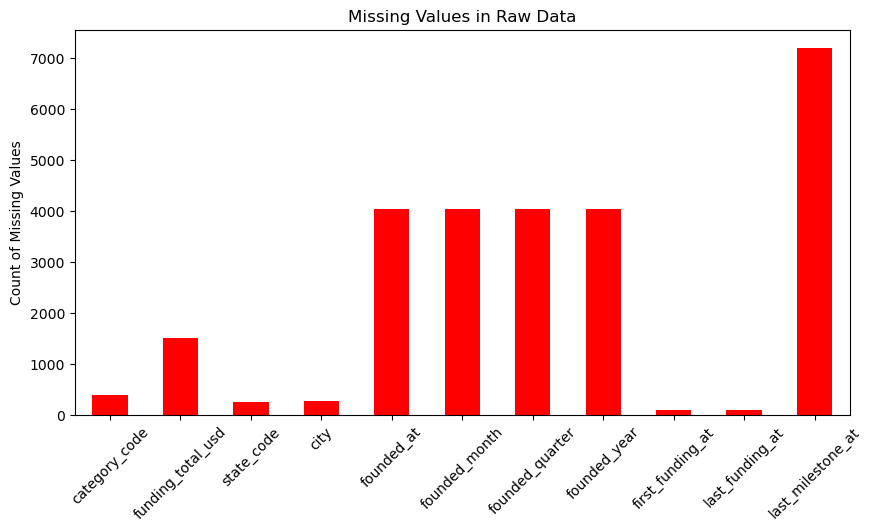

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load raw dataset
companies = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-companies.csv", encoding='latin1', low_memory=False)

# Count missing values
missing_values = companies.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Keep only columns with missing values

# Plot
plt.figure(figsize=(10, 5))
missing_values.plot(kind='bar', color='red')
plt.title("Missing Values in Raw Data")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45)
plt.show()


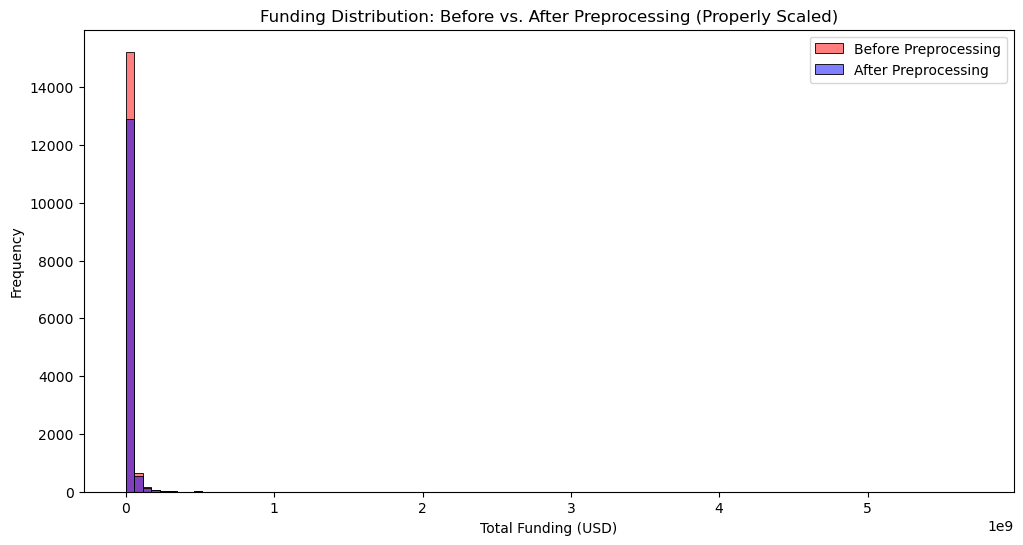

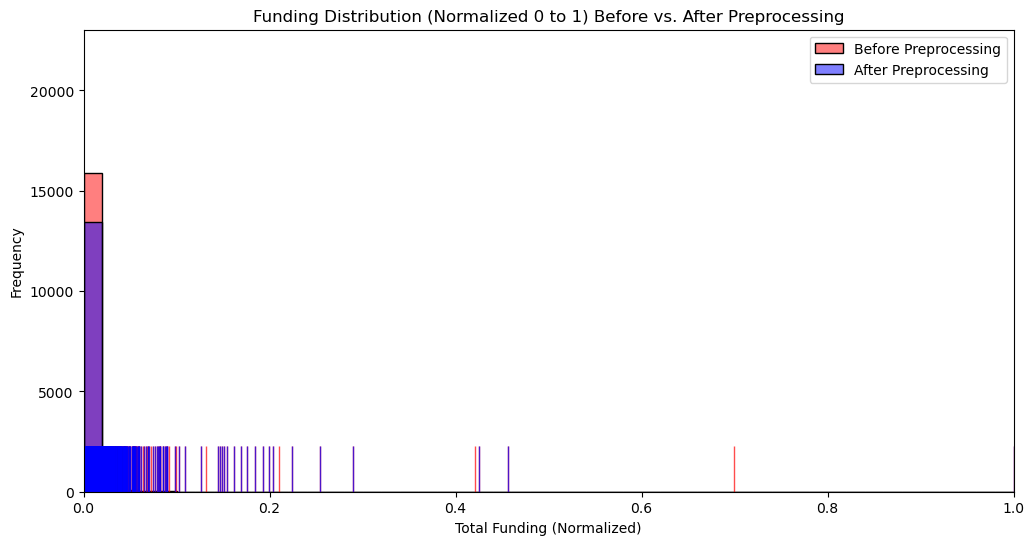

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
raw_df = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-companies.csv", encoding='latin1', low_memory=False)
processed_df = pd.read_csv("/Users/macbook/Downloads/preprocessed_startup_data_2013_fixed.csv")

# 🔹 Convert funding columns to numeric (Fix TypeError)
raw_df['funding_total_usd'] = pd.to_numeric(raw_df['funding_total_usd'], errors='coerce')
processed_df['total_funding_received'] = pd.to_numeric(processed_df['total_funding_received'], errors='coerce')

# 🔹 Adjust for Preprocessed Scaling (Assumes MinMaxScaler Was Used)
if processed_df['total_funding_received'].max() <= 1.0:
    max_funding = raw_df['funding_total_usd'].max()  # Get original max value
    processed_df['total_funding_received'] *= max_funding  # Scale it back

# 🔹 Wider Histogram for Better Comparison
plt.figure(figsize=(12, 6))  # Increase width
sns.histplot(raw_df['funding_total_usd'].dropna(), bins=100, color='red', label='Before Preprocessing', alpha=0.5)
sns.histplot(processed_df['total_funding_received'].dropna(), bins=100, color='blue', label='After Preprocessing', alpha=0.5)

plt.title("Funding Distribution: Before vs. After Preprocessing (Properly Scaled)")
plt.xlabel("Total Funding (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load datasets
raw_df = pd.read_csv("/Users/macbook/Downloads/archive/crunchbase-companies.csv", encoding='latin1', low_memory=False)
processed_df = pd.read_csv("/Users/macbook/Downloads/preprocessed_startup_data_2013_fixed.csv")

# 🔹 Convert funding columns to numeric
raw_df['funding_total_usd'] = pd.to_numeric(raw_df['funding_total_usd'], errors='coerce')
processed_df['total_funding_received'] = pd.to_numeric(processed_df['total_funding_received'], errors='coerce')

# 🔹 Normalize both datasets to the range [0,1] using MinMaxScaler
scaler = MinMaxScaler()
raw_df['funding_normalized'] = scaler.fit_transform(raw_df[['funding_total_usd']])
processed_df['funding_normalized'] = scaler.fit_transform(processed_df[['total_funding_received']])

# 🔹 Wider Histogram with Data Points (Rug Plot)
plt.figure(figsize=(12, 6))  # Increase width

sns.histplot(raw_df['funding_normalized'].dropna(), bins=50, color='red', label='Before Preprocessing', alpha=0.5)
sns.histplot(processed_df['funding_normalized'].dropna(), bins=50, color='blue', label='After Preprocessing', alpha=0.5)

# 🔹 Add individual data points using a Rug Plot
sns.rugplot(raw_df['funding_normalized'].dropna(), color='red', height=0.1, alpha=0.7)  # Red = Raw Data
sns.rugplot(processed_df['funding_normalized'].dropna(), color='blue', height=0.1, alpha=0.7)  # Blue = Processed Data

plt.title("Funding Distribution (Normalized 0 to 1) Before vs. After Preprocessing")
plt.xlabel("Total Funding (Normalized)")
plt.ylabel("Frequency")
plt.xlim(0, 1)  # Ensure x-axis is between 0 and 1
plt.legend()
plt.show()


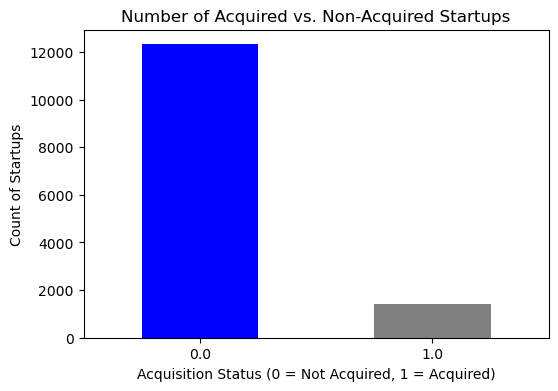

In [52]:
plt.figure(figsize=(6, 4))
processed_df['acquired'].value_counts().plot(kind='bar', color=['blue', 'gray'])
plt.title("Number of Acquired vs. Non-Acquired Startups")
plt.xlabel("Acquisition Status (0 = Not Acquired, 1 = Acquired)")
plt.ylabel("Count of Startups")
plt.xticks(rotation=0)
plt.show()
